# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
* Price - цена

## Подготовка данных

Загрузим все необходимые библиотеки и инструменты:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv('/datasets/autos.csv')
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Присутствуют пропуски в столбцах VehicleType, Gearbox, FuelType и Repaired. Изучим, какие данные есть в каждом столбце.

In [ ]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [ ]:
show_rows(data)

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

1. В столбце RegistrationYear существуют некорректные значения года регистрации.
2. В столбце RegistrationMonth отсутсвует месяц регистрации.
3. В столбце Power присутвует некорректное значение мощности.

Определим признаки, важные для модели.

К значимым признакам отнесем следующие столбцы:

* VehicleType. Тип машины определяет ее функционал. Чем больше возможностей у машины, тем выше цена.
* Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
* Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
* Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
* FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
* Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
* Repaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
* RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
* Model. В купе с типом машины и брендом може влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость.

Сократим дата фрейм до нужных столбцов:

In [ ]:
df = data[['VehicleType',
                         'Gearbox',
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Столбцы требующие обработки:

* VehicleType. Восстановим пропущенные значения по популярному типу из столбца Brand.
* Gearbox. Для всех NaN установим значение 'manual'.
* Power. Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
* FuelType. Восстановим пропущенные значения по популярному типу из столбца Brand.
* Repaired. Для всех NaN установим значение 'yes'.
* RegistrationYear. Скоректируем на основе реальных значений в машинах.
* Model. Для всех NaN установим значение 'unknown'.

Проверим наполнение целевого признака Price.

In [ ]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Видно, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

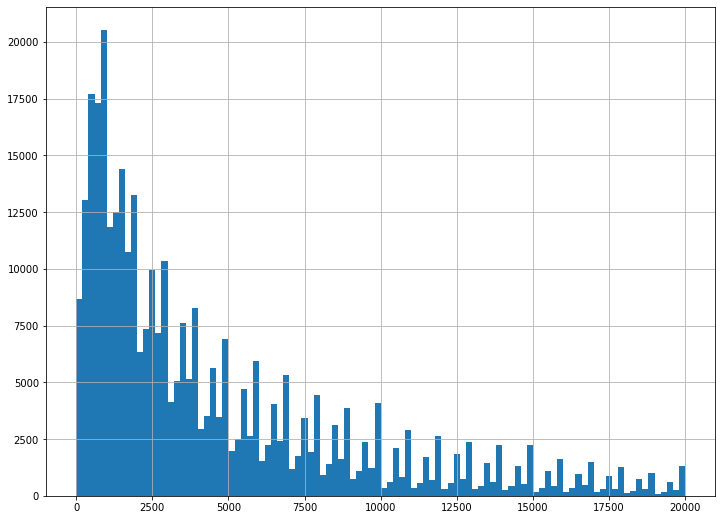

In [ ]:
df = df.query('Price > 0')
df['Price'].hist(bins=100, figsize=(12,9))
df['Price'].describe()

Выделим квантили 5% и 80%.

In [ ]:
df['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64


Стоимость 350 евро примерно равно 28000 рублей. Это минимальная цена для продажи поддержанного авто. Выбор 80% квантиля обоснован болльшими выбросами после 7500 евро.

In [ ]:
df = df.query('350 <= Price <= 7800')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259798 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233267 non-null  object
 1   Gearbox           246646 non-null  object
 2   Power             259798 non-null  int64 
 3   Kilometer         259798 non-null  int64 
 4   FuelType          236972 non-null  object
 5   Brand             259798 non-null  object
 6   Repaired          206998 non-null  object
 7   RegistrationYear  259798 non-null  int64 
 8   Model             246358 non-null  object
 9   Price             259798 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


Проверим значения столбца RegistrationYear на гистограмме.

count    259798.000000
mean       2002.844976
std          65.140145
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

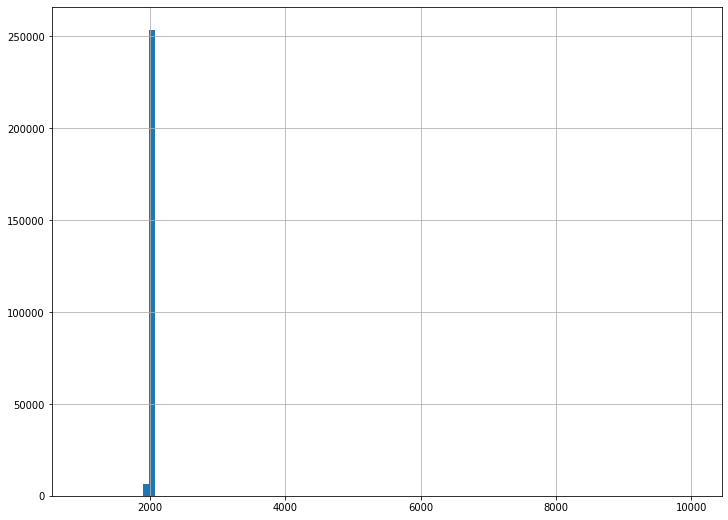

In [ ]:
df['RegistrationYear'].hist(bins=100, figsize=(12,9))
df['RegistrationYear'].describe()

В годе регистрации наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.

In [ ]:
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

count    247788.000000
mean       2001.539179
std           6.112319
min        1910.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

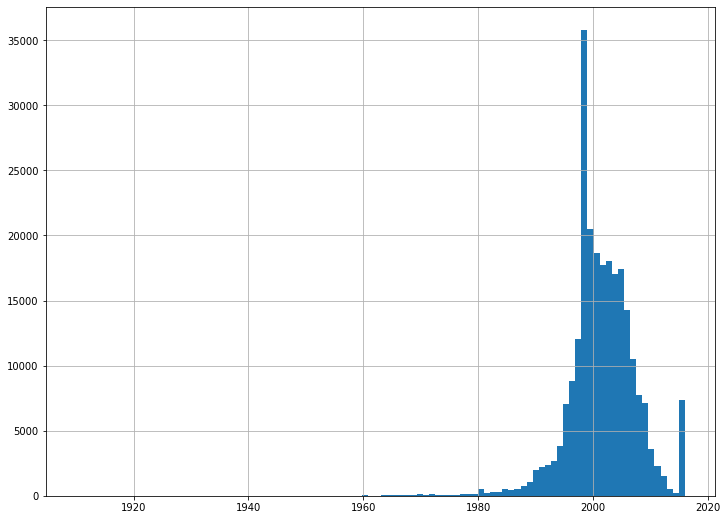

In [ ]:
df = df.query('1899 < RegistrationYear < 2017')
df['RegistrationYear'].hist(bins=100, figsize=(12,9))
df['RegistrationYear'].describe()

По левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, так как это старые, но возможно еще работающие машины.

count    247665.000000
mean       2001.567440
std           5.968335
min        1960.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

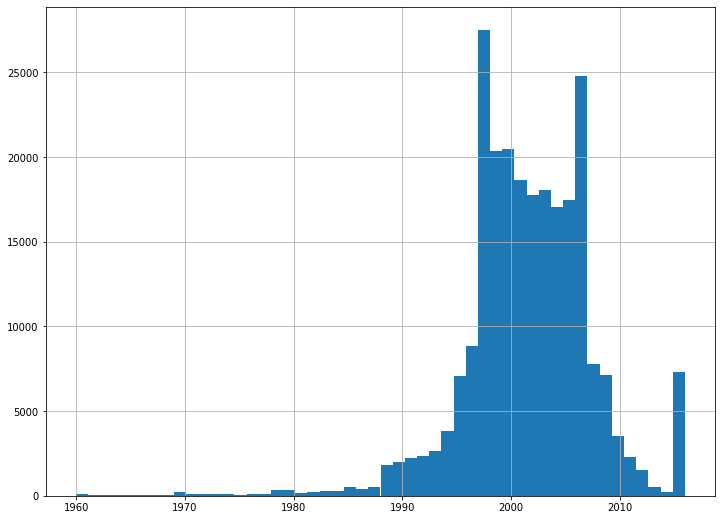

In [ ]:
df = df.query('1959 < RegistrationYear < 2017')
df['RegistrationYear'].hist(bins=50, figsize=(12,9))
df['RegistrationYear'].describe()

<div class="alert alert-success">
    ✔️ <b>Комментарий ревьюера</b>

Абсолютно согласен с рассуждениями. Круто, что смотришь на дату выгрузки.
</div>

Проведем замену NaN в Gearbox, NotRepaired и Model.

In [ ]:
df.fillna({'Gearbox':'manual',
           'Repaired':'yes',
           'Model':'unknown'},
           inplace=True)
df.isna().mean()

VehicleType         0.058640
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.073575
Brand               0.000000
Repaired            0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

Оценим количество пропущенных значений относительно всех значений в столбце VehicleType

In [ ]:
display(df['VehicleType'].value_counts())
df['VehicleType'].isna().sum()

sedan          67609
small          66486
wagon          47300
bus            21087
convertible    12662
coupe          10311
suv             5237
other           2450
Name: VehicleType, dtype: int64

14523

Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [ ]:
vehicle_type_pivot_table = df.pivot_table(index=['VehicleType'],
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
df[df['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      98.0    370.0  1040.0   15.0   
convertible      111.0   667.0   1636.0       6.0    195.0    96.0    NaN   
coupe            180.0   651.0   2570.0      45.0     17.0   137.0    NaN   
other             10.0    83.0    187.0      18.0      6.0    95.0    5.0   
sedan            777.0  7828.0  11309.0     146.0    205.0   538.0   97.0   
small            185.0   933.0    324.0     574.0     12.0  1372.0  178.0   
suv                NaN    18.0    189.0     146.0     12.0     8.0   46.0   
wagon            388.0  6422.0   4997.0      83.0    183.0   497.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   707.0  ...   485.0   158.0     1.0   
convertible    1.0      8.0   257.0  ...     NaN     3.0   988.0   
coupe          2.0      NaN   151.0  ...    64.0     6.0   318.0   
other          5.0      9.0   151.0  ...    47.0    21.0     8.0   
sedan         87.0     35.0   796.0  ...  1220.0   694.0    26.0   
small        247.0    439.0  4520.0  ...  2621.0   930.0  3099.0   
suv            1.0     46.0    17.0  ...     1.0     7.0     NaN   
wagon         36.0     16.0   370.0  ...   215.0  1763.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  140.0   16.0   27.0   341.0     NaN     5936.0     NaN  
convertible          161.0    NaN   32.0    47.0    30.0     2029.0    35.0  
coupe                 79.0    3.0    4.0   178.0     2.0      740.0    50.0  
other                167.0    5.0   10.0    15.0     4.0      586.0     NaN  
sedan                257.0   99.0  131.0   735.0   170.0    14847.0   487.0  
small                166.0   99.0  810.0  1475.0    49.0    15294.0     6.0  
suv                  174.0   42.0  557.0   252.0     NaN      247.0    30.0  
wagon                104.0  241.0   84.0   449.0    66.0     9704.0  1655.0  

[8 rows x 40 columns]

sedan          777
wagon          388
small          185
coupe          180
convertible    111
other           10
Name: VehicleType, dtype: int64

In [ ]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,4.0,98.0,370.0,1040.0,15.0,26.0,31.0,707.0,...,485.0,158.0,1.0,140.0,16.0,27.0,341.0,NaN,5936.0,NaN
convertible,111.0,667.0,1636.0,6.0,195.0,96.0,NaN,1.0,8.0,257.0,...,NaN,3.0,988.0,161.0,NaN,32.0,47.0,30.0,2029.0,35.0
coupe,180.0,651.0,2570.0,45.0,17.0,137.0,NaN,2.0,NaN,151.0,...,64.0,6.0,318.0,79.0,3.0,4.0,178.0,2.0,740.0,50.0
other,10.0,83.0,187.0,18.0,6.0,95.0,5.0,5.0,9.0,151.0,...,47.0,21.0,8.0,167.0,5.0,10.0,15.0,4.0,586.0,NaN
sedan,777.0,7828.0,11309.0,146.0,205.0,538.0,97.0,87.0,35.0,796.0,...,1220.0,694.0,26.0,257.0,99.0,131.0,735.0,170.0,14847.0,487.0
small,185.0,933.0,324.0,574.0,12.0,1372.0,178.0,247.0,439.0,4520.0,...,2621.0,930.0,3099.0,166.0,99.0,810.0,1475.0,49.0,15294.0,6.0
suv,NaN,18.0,189.0,146.0,12.0,8.0,46.0,1.0,46.0,17.0,...,1.0,7.0,NaN,174.0,42.0,557.0,252.0,NaN,247.0,30.0
wagon,388.0,6422.0,4997.0,83.0,183.0,497.0,227.0,36.0,16.0,370.0,...,215.0,1763.0,9.0,104.0,241.0,84.0,449.0,66.0,9704.0,1655.0


Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247665 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233142 non-null  object
 1   Gearbox           247665 non-null  object
 2   Power             247665 non-null  int64 
 3   Kilometer         247665 non-null  int64 
 4   FuelType          229443 non-null  object
 5   Brand             247665 non-null  object
 6   Repaired          247665 non-null  object
 7   RegistrationYear  247665 non-null  int64 
 8   Model             247665 non-null  object
 9   Price             247665 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


In [ ]:
df.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

df['VehicleType'] = df.apply(
                                fillna_by_brand,
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(df['VehicleType'].isna().sum())
df['VehicleType'].value_counts()

0

small          76545
sedan          71693
wagon          47556
bus            21144
convertible    12662
coupe          10330
suv             5285
other           2450
Name: VehicleType, dtype: int64

Заполним пропуски в FuelType по похожему принципу

In [ ]:
df['FuelType'].value_counts()
fuel_type_pivot_table = df.pivot_table(index=['FuelType'],
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

df.fillna({'FuelType':0},inplace=True)

df['FuelType'] = df.apply(
                                fillna_by_brand,
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(df['FuelType'].isna().sum())
df['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,6.0,4.0,NaN,7.0,2.0,NaN,NaN,63.0,...,NaN,4.0,2.0,NaN,2.0,NaN,NaN,NaN,125.0,14.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,16.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,480.0,6502.0,5073.0,66.0,264.0,1181.0,98.0,1.0,4.0,1243.0,...,1229.0,1145.0,807.0,297.0,10.0,145.0,679.0,1.0,16655.0,582.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,NaN,NaN,NaN,35.0,NaN,5.0,NaN
lpg,30.0,356.0,606.0,139.0,77.0,63.0,35.0,23.0,5.0,64.0,...,56.0,48.0,3.0,58.0,25.0,18.0,18.0,NaN,454.0,100.0
other,NaN,2.0,5.0,NaN,NaN,2.0,NaN,1.0,NaN,3.0,...,NaN,NaN,1.0,16.0,NaN,1.0,NaN,31.0,14.0,2.0
petrol,1124.0,9465.0,14948.0,884.0,642.0,2499.0,424.0,374.0,564.0,5496.0,...,3333.0,2333.0,3604.0,784.0,453.0,1457.0,2736.0,242.0,31839.0,1507.0


0

petrol      162858
gasoline     61661
small        12152
sedan         5523
lpg           4241
cng            431
wagon          390
other          115
hybrid          83
bus             74
suv             62
electric        54
coupe           21
Name: FuelType, dtype: int64

In [ ]:
df.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

Пропуски убраны. Осталось заняться некорректнымми значениями в столбце Power.

count    247665.000000
mean        102.053181
std         182.583893
min           0.000000
25%          67.000000
50%         101.000000
75%         131.000000
max       20000.000000
Name: Power, dtype: float64

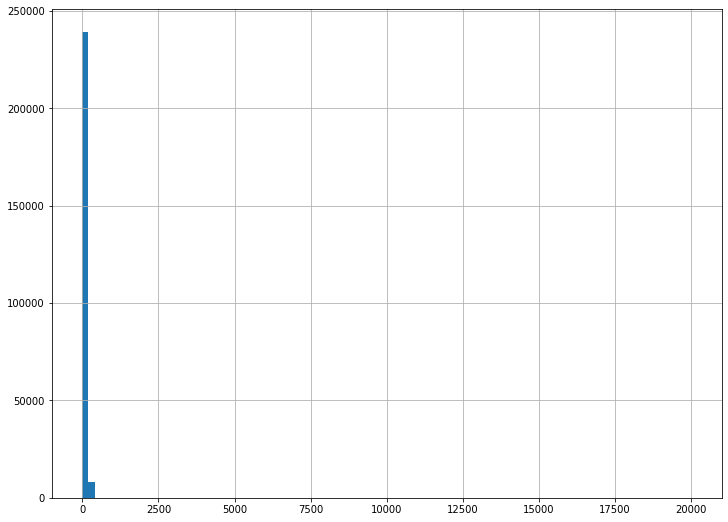

In [ ]:
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()

Раброс очень сильный, усечем выбросы больше 1000 л.с.

count    247451.000000
mean         98.693652
std          54.774902
min           0.000000
25%          67.000000
50%         101.000000
75%         131.000000
max        1000.000000
Name: Power, dtype: float64

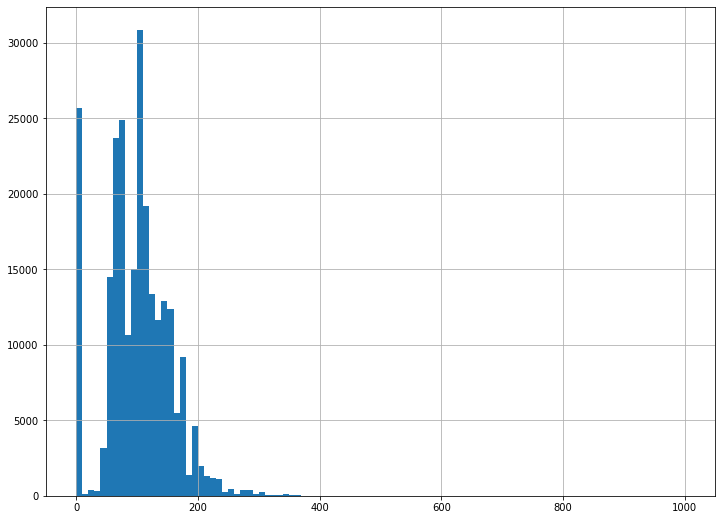

In [ ]:
df = df.query('Power < 1001')
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()

Из графика видно, что многие машины имеют мощность 0. Эти строки не подлежат восстановлению и будут удалены. По правому отсечению выбреме границу в 400 л.с.

count    221862.000000
mean        109.824012
std          44.434962
min           1.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         400.000000
Name: Power, dtype: float64

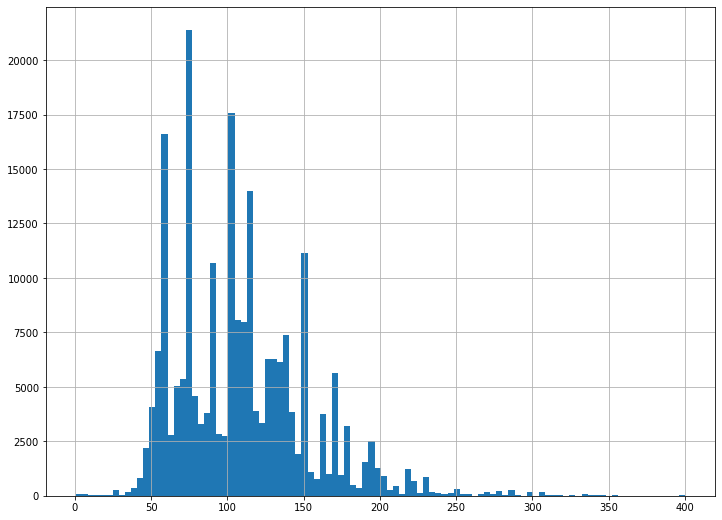

In [ ]:
df = df.query('0 < Power < 401')
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()

Следующими границами выберем 25 и 350 л.с.

count    221412.000000
mean        109.878900
std          43.985727
min          25.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         350.000000
Name: Power, dtype: float64

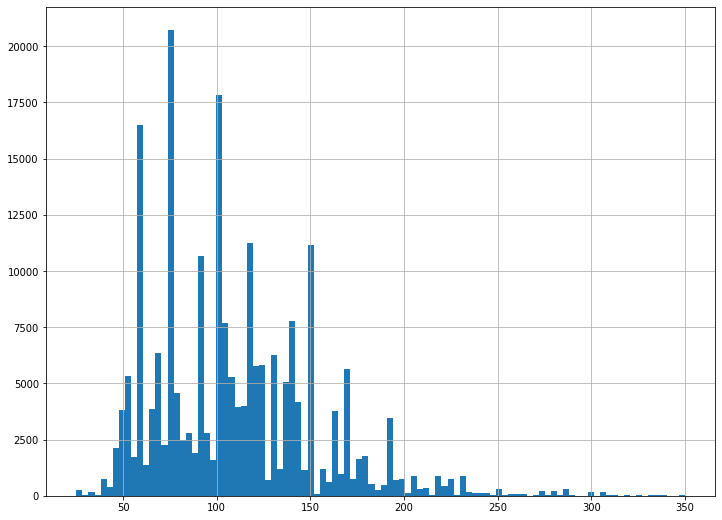

In [ ]:
pure_df = df.query('24 < Power < 351')
pure_df['Power'].hist(bins = 100, figsize = (12, 9))
pure_df['Power'].describe()

In [ ]:
pure_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Gearbox           221412 non-null  object
 2   Power             221412 non-null  int64 
 3   Kilometer         221412 non-null  int64 
 4   FuelType          221412 non-null  object
 5   Brand             221412 non-null  object
 6   Repaired          221412 non-null  object
 7   RegistrationYear  221412 non-null  int64 
 8   Model             221412 non-null  object
 9   Price             221412 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.6+ MB


Проведем замену столбцов Gearbox и Repaired на булев тип.

* IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
* IsRepaired. 1(yes) - означает машину с ремонтом. 0(no) - без ремонта.

In [ ]:
pure_df['IsManualGearbox'] = 0
pure_df.loc[pure_df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(pure_df['IsManualGearbox'].value_counts())
pure_df['Gearbox'].value_counts()

1    186647
0     34765
Name: IsManualGearbox, dtype: int64

manual    186647
auto       34765
Name: Gearbox, dtype: int64

In [ ]:
pure_df['IsRepaired'] = 1
pure_df.loc[pure_df['Repaired'] == 'yes', 'IsRepaired'] = 0
display(pure_df['IsRepaired'].value_counts())
pure_df['Repaired'].value_counts()

1    163035
0     58377
Name: IsRepaired, dtype: int64

no     163035
yes     58377
Name: Repaired, dtype: int64

Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом.



In [ ]:
pure_df.drop(['Repaired','Gearbox'], inplace=True, axis=1)
pure_df['IsRepaired'] = pd.to_numeric(pure_df['IsRepaired'], downcast='integer')
pure_df['IsManualGearbox'] = pd.to_numeric(pure_df['IsManualGearbox'], downcast='integer')
pure_df['RegistrationYear'] = pd.to_numeric(pure_df['RegistrationYear'], downcast='integer')
pure_df['Power'] = pd.to_numeric(pure_df['Power'], downcast='integer')
pure_df['Kilometer'] = pd.to_numeric(pure_df['Kilometer'], downcast='integer')
pure_df['Price'] = pd.to_numeric(pure_df['Price'], downcast='integer')
pure_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Power             221412 non-null  int16 
 2   Kilometer         221412 non-null  int32 
 3   FuelType          221412 non-null  object
 4   Brand             221412 non-null  object
 5   RegistrationYear  221412 non-null  int16 
 6   Model             221412 non-null  object
 7   Price             221412 non-null  int16 
 8   IsManualGearbox   221412 non-null  int8  
 9   IsRepaired        221412 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 11.0+ MB


**Итого по подготовке данных:**

1. Была изучена таблица данных.
2. Выведены аномальные и пропущенные значения.
3. Отобраны небходимые столбцы для обучения модели.
4. Заполнены пропуски в столбцах и удалены некорректные значения.
5. Заменены два категориальных признака на численные.

## Обучение моделей

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. DecisionTreeRegressor
3. CatBoostRegressor
4. LGBMRegressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

Подготовим три типа признаков для кроссвалидации:

* Неизмененные. Название original_features.
* Закодированные методом OHE. Название ohe_features.
* Закодированные методом OE. Название ordinal_features.

In [ ]:
#Неизмененные принаки
original_features = pure_df.drop('Price', axis=1)
#Целевой признак
target = pure_df['Price']

original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=19072020)

In [ ]:
#OE training
encoder = OrdinalEncoder(handle_unknown = 'ignore')
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features_train = original_features_train[cat_columns]
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train[cat_columns]),
                            columns=cat_features_train.columns,
                            index=cat_features_train.index)

In [ ]:
#проверим кодирование
cat_features_train[cat_columns].head(10)

,VehicleType,FuelType,Brand,Model
272668,5.0,4.0,38.0,171.0
224663,5.0,8.0,27.0,75.0
253593,2.0,8.0,38.0,194.0
22246,2.0,4.0,24.0,42.0
186689,1.0,8.0,2.0,11.0
311191,5.0,8.0,21.0,80.0
243065,4.0,8.0,20.0,221.0
238781,7.0,4.0,20.0,95.0
327939,4.0,8.0,1.0,32.0
295910,7.0,8.0,38.0,115.0


In [ ]:
ordinal_features_train = original_features_train.copy()
for column in cat_columns:
    ordinal_features_train[column] = cat_features_train[column]

In [ ]:
ordinal_features_train.head()

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,IsManualGearbox,IsRepaired
272668,5.0,75,150000,4.0,38.0,2005,171.0,1,1
224663,5.0,55,150000,8.0,27.0,1999,75.0,1,1
253593,2.0,90,150000,8.0,38.0,1986,194.0,1,1
22246,2.0,120,150000,4.0,24.0,2005,42.0,1,1
186689,1.0,170,100000,8.0,2.0,2001,11.0,0,1


In [ ]:
#OE transforming
#original_features_test[cat_columns] = encoder.transform(original_features_test[cat_columns])
cat_features_test = original_features_test[cat_columns]
cat_features_test = pd.DataFrame(encoder.transform(cat_features_test[cat_columns]),
                                columns = cat_features_test.columns,
                                index = cat_features_test.index)

In [ ]:
cat_features_test.head(5)

,VehicleType,FuelType,Brand,Model
334426,4.0,8.0,36.0,82.0
247064,4.0,8.0,24.0,228.0
73840,5.0,4.0,24.0,83.0
158141,5.0,4.0,27.0,220.0
41777,5.0,8.0,27.0,134.0


In [ ]:
ordinal_features_test = original_features_test.copy()
for column in cat_columns:
    ordinal_features_test[column] = cat_features_test[column]

In [ ]:
ordinal_features_test.head()

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,IsManualGearbox,IsRepaired
334426,4.0,224,150000,8.0,36.0,2006,82.0,1,1
247064,4.0,101,150000,8.0,24.0,1998,228.0,1,1
73840,5.0,75,125000,4.0,24.0,2006,83.0,1,1
158141,5.0,64,125000,4.0,27.0,2009,220.0,1,1
41777,5.0,121,125000,8.0,27.0,2016,134.0,1,1


In [ ]:
#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

In [ ]:
ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### Линейная регрессия

In [ ]:
%%time

regressor = LinearRegression()
cv_RMSE_LR = (cross_val_score(regressor,
                             ohe_features_train,
                             target_train,
                             cv=5,
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средняя RMSE =', cv_RMSE_LR)

Средняя RMSE = 1352.5105514215822
CPU times: user 36 s, sys: 16.5 s, total: 52.5 s
Wall time: 52.7 s


In [ ]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train,
                                target_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средняя RMSE = =', cv_RMSE_LR_S)

Средняя RMSE = = 3164860214631.0747
CPU times: user 39.4 s, sys: 23 s, total: 1min 2s
Wall time: 1min 2s


Масштабирование признаков ухудшает модель. Откажемся от применения масштаба.

### DecisionTreeRegressor

1. Проверим модель на признаках, закодированных методом OHE
2. Проверим модель на признаках, закодированных методом OE

In [ ]:
%%time

regressor = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list,
                'random_state':[19072020]}]
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Параметры:")
print()
print(clf.best_params_)
print()
print("Шаги:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

Параметры:

{'criterion': 'mse', 'max_depth': 16, 'random_state': 19072020}

Шаги:

1554.914430 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 19072020}
1471.926202 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 19072020}
1379.420752 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 19072020}
1305.285265 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 19072020}
1256.028154 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 19072020}
1211.103712 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 19072020}
1177.874799 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 19072020}
1147.173022 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 19072020}
1120.949483 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 19072020}
1099.359481 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 19072020}
1081.631412 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 19072020}
1073.114086 for {'criterion': 'mse', 'max_de

In [ ]:
%%time

regressor = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list,
                'random_state':[19072020]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметры:")
print()
print(clf.best_params_)
print()
print("Шаги:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Параметры:

{'criterion': 'mse', 'max_depth': 13, 'random_state': 19072020}

Шаги:

1554.914430 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 19072020}
1470.524123 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 19072020}
1377.618929 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 19072020}
1303.101874 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 19072020}
1253.195866 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 19072020}
1207.271591 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 19072020}
1169.537752 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 19072020}
1138.734730 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 19072020}
1112.569500 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 19072020}
1091.903331 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 19072020}
1077.866927 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 19072020}
1072.001611 for {'criterion': 'mse', 'max_de

Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.


### CatBoostRegressor

1. Обучим модель на данных, закодированных по методу OE.
2. Обучим на оригинальных данных с указанием категорий.

In [ ]:
%%time

regressor = CatBoostRegressor()
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[19072020],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметры:")
print()
print(clf.best_params_)
print()
print("Шаги:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

Параметры:

{'learning_rate': 0.5, 'random_state': 19072020, 'verbose': False}

Шаги:

939.604493 for {'learning_rate': 0.1, 'random_state': 19072020, 'verbose': False}
930.361660 for {'learning_rate': 0.5, 'random_state': 19072020, 'verbose': False}
945.457291 for {'learning_rate': 0.8, 'random_state': 19072020, 'verbose': False}

CPU times: user 3min 58s, sys: 1.51 s, total: 4min
Wall time: 4min 12s


In [ ]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=19072020,
                              verbose=False,
                              cat_features=['VehicleType','FuelType','Brand','Model'])
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train,
                                target_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средняя RMSE =', cv_RMSE_CBR_original)

Средняя RMSE = 945.9868820577402
CPU times: user 1min 19s, sys: 581 ms, total: 1min 20s
Wall time: 1min 23s


### LGBMRegressor

In [ ]:
%%time

regressor = LGBMRegressor()
hyperparams = [{'num_leaves':[31, 100, 200],
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[19072020]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметры:")
print()
print(clf.best_params_)
print()
print("Шаги:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Параметры:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 19072020}

Шаги:

977.387856 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 19072020}
941.039455 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 19072020}
926.849170 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 19072020}
950.513005 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 19072020}
932.675698 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 19072020}
926.500546 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 19072020}
950.527659 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 19072020}
942.804030 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 19072020}
944.487988 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 19072020}

CPU times: user 4min 41s, sys: 578 ms, total: 4min 42s
Wall time: 4min 43s


**Итого по обучению моделей:**

Мы изучили 4 регрессионные модели, зафиксировали лучшие гиперпараметры и время их выполнения для дальнейшего сравнения.

## Анализ моделей

Проведем обучение на каждой модели с лучшими гиперпараметрами:

### LinearRegresion

In [ ]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 8.68 s, sys: 3.34 s, total: 12 s
Wall time: 12 s


LinearRegression()

In [ ]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 109 ms, sys: 73.4 ms, total: 182 ms
Wall time: 159 ms


In [ ]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
cross_val_RMSE_LR = cross_val_score(model,
                                    ohe_features_train,
                                    target_train,
                                    cv = 5,
                                    scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_LR = abs(cross_val_RMSE_LR).mean()

### DecisionTreeRegressor

In [ ]:
%%time

model = DecisionTreeRegressor(criterion='mse',
                              max_depth=15,
                              random_state=19072020)
model.fit(ohe_features_train, target_train)

CPU times: user 3.12 s, sys: 112 ms, total: 3.24 s
Wall time: 3.24 s


DecisionTreeRegressor(max_depth=15, random_state=19072020)

In [ ]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 28.7 ms, sys: 41.9 ms, total: 70.6 ms
Wall time: 75.3 ms


In [ ]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
cross_val_RMSE_DTR_ohe = cross_val_score(model,
                                         ohe_features_train,
                                         target_train,
                                        cv = 5,
                                        scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_DTR_ohe = abs(cross_val_RMSE_DTR_ohe).mean()

In [ ]:
%%time

model = DecisionTreeRegressor(criterion='mse',
                              max_depth=13,
                              random_state=19072020)
model.fit(ordinal_features_train, target_train)

CPU times: user 274 ms, sys: 4.54 ms, total: 278 ms
Wall time: 277 ms


DecisionTreeRegressor(max_depth=13, random_state=19072020)

In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 10.4 ms, sys: 185 µs, total: 10.6 ms
Wall time: 9.23 ms


In [ ]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
print(final_RMSE_DTR_ordinal)

1055.7694496844765


In [ ]:
cross_val_RMSE_DTR_ordinal = cross_val_score(model,
                                        ordinal_features_train,
                                        target_train,
                                        cv = 5,
                                        scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_DTR_ordinal = abs(cross_val_RMSE_DTR_ordinal).mean()

### CatBoostRegressor

In [ ]:
%%time

model = CatBoostRegressor(learning_rate=0.5,
                          random_state=19072020,
                          verbose=False)
model.fit(ordinal_features_train, target_train)

CPU times: user 18.6 s, sys: 157 ms, total: 18.8 s
Wall time: 19.6 s


In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 48.7 ms, sys: 197 µs, total: 48.9 ms
Wall time: 47.2 ms


In [ ]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
cross_val_RMSE_CBR_ordinal = cross_val_score(model,
                                        ordinal_features_train,
                                        target_train,
                                        cv = 5,
                                        scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_CBR_ordinal = abs(cross_val_RMSE_CBR_ordinal).mean()

In [ ]:
%%time

model = CatBoostRegressor(learning_rate=0.5,
                          iterations = 200,
                          random_state=19072020,
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model'])
model.fit(original_features_train, target_train)

CPU times: user 20.6 s, sys: 169 ms, total: 20.8 s
Wall time: 21.3 s


In [ ]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 120 ms, sys: 347 µs, total: 121 ms
Wall time: 119 ms


In [ ]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5


In [ ]:
cross_val_RMSE_CBR_original = cross_val_score(model,
                                        original_features_train,
                                        target_train,
                                        cv = 5,
                                        scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_CBR_original = abs(cross_val_RMSE_CBR_original).mean()

### LGBMRegressor

In [ ]:
%%time

model = LGBMRegressor(learning_rate=0.1,
                      num_leaves=200,
                      random_state=19072020)
model.fit(ordinal_features_train, target_train)

CPU times: user 9.64 s, sys: 26.1 ms, total: 9.66 s
Wall time: 9.67 s


LGBMRegressor(num_leaves=200, random_state=19072020)

In [ ]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 622 ms, sys: 0 ns, total: 622 ms
Wall time: 607 ms


In [ ]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [ ]:
cross_val_RMSE_LGBMR = cross_val_score(model,
                                      ordinal_features_train,
                                        target_train,
                                        cv = 5,
                                        scoring = 'neg_root_mean_squared_error')

In [ ]:
rmse_LGBMR = abs(cross_val_RMSE_LGBMR).mean()

### Сравнение моделей

In [ ]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[rmse_LR,
                            rmse_DTR_ohe,
                            rmse_DTR_ordinal,
                            rmse_CBR_ordinal,
                            rmse_CBR_original,
                            rmse_LGBMR],
        'Время обучения на CV, сек':[52.7,
                                     62,
                                     360,
                                     37.7,
                                     252,
                                     83],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[12,
                                      3.24,
                                      0.277,
                                      19.6,
                                      21.3,
                                      9.67],
        'Время предсказания модели, сек':[0.159,
                                          0.075,
                                          0.009,
                                          0.047,
                                          0.119,
                                          0.607]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() /
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() /
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,1352.505668,52.7,1343.280265,12.000,0.159,0.685271,0.023083,0.056604,0.764958
DecisionTreeRegressor on OHE features,1066.418604,62.0,1042.580004,3.240,0.075,0.869108,0.085494,0.120000,1.074602
DecisionTreeRegressor on OE features,1071.977879,360.0,1055.769450,0.277,0.009,0.864601,1.000000,1.000000,2.864601
CatBoostRegressor on OE features,930.332286,37.7,917.588314,19.600,0.047,0.996239,0.014133,0.191489,1.201861
CatBoostRegressor on original features,945.968410,252.0,935.844645,21.300,0.119,0.979772,0.013005,0.075630,1.068407
LGBMRegressor,926.833389,83.0,917.248036,9.670,0.607,1.000000,0.028645,0.014827,1.043472


# Итого

В ходе работы было выполнено:

1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минмальным временем или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению. Считаем, что все параметры равноценны.

На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.

1. Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.
2. Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и DecisionTreeRegressor занимает третье место.
3. LinearRegression показал себя на этой задаче очень слабо.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.

* Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.
* Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.
* Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.